In [1]:
Threads.nthreads()

6

In [2]:
using Gridap
import Gridap: ∇
using LinearAlgebra
using GridapGmsh

In [3]:
using Gridap.Arrays
using Gridap.TensorValues
using Gridap.ReferenceFEs
using Gridap.Geometry
using Gridap.Fields
using Gridap.Algebra
using SparseArrays
using Gridap.FESpaces
using Gridap.CellData
using Plots

In [4]:
#Mallado
model = GmshDiscreteModel("test-gridap/circle.msh")
const global degree = 1
Ω = Triangulation(model)
dΩ = Measure(Ω,2*degree)
quad = CellQuadrature(Ω,degree)

Info    : Reading 'test-gridap/circle.msh'...
Info    : 423 nodes
Info    : 844 elements
Info    : Done reading 'test-gridap/circle.msh'


CellQuadrature()

In [19]:
#Parámetros
gamma = 0.95
ro = 0.99
alpha = 0.02
betaf(x) = VectorValue(-x[2],x[1]) #vector de transporte

t_init = 0.
t_end = 2*π

N_intervalos = 200;

n_iter = 5;
T = LinRange(t_init, t_end, N_intervalos+1);

In [20]:
#Espacio de funciones
order = 1
reffe = ReferenceFE(lagrangian,Float64,order)
V0 = TestFESpace(model,reffe)

U = TrialFESpace(V0)

UnconstrainedFESpace()

In [21]:
#La formula de cuadratura para la forma bilineal int(u*v), 
#cambia el orden por ser producto de dos polinomios (cada uno de orden "degree")
quadL2 = CellQuadrature(Ω,degree)

CellQuadrature()

In [22]:
#Valores iniciales
x0, y0 = 0.3, 0.3 

S0(x) = 10 -  4*exp(-200*((x[1]-x0)^2 + (x[2]-y0)^2))
I0(x) = 4*exp(-200*((x[1]-x0)^2 + (x[2]-y0)^2))
R0(x) = 0

#S0_sol = project(S0, Ω, quadL2, 1)
#I0_sol = project(I0, trian, quadL2, 1)
#R0_sol = project(R0, trian, quadL2, 1)

U_init = [S0, I0, R0]

3-element Array{Function,1}:
 S0 (generic function with 1 method)
 I0 (generic function with 1 method)
 R0 (generic function with 1 method)

In [23]:
function MassLumping(M)
    n = size(M)[1]
    ML = zeros(n,n)
    for i = 1:n
        ML[i,i] = sum(M[i,:])
        end
    return ML
end

MassLumping (generic function with 1 method)

In [24]:
function AddDifussion(C)
    n = size(C)[1]
    L = zeros(n,n)
    for i=1:n
        d_diag = 0
        for j =1:(i-1)
            d = max(-C[i,j],0, -C[j,i])
            L[i,j]= C[i,j] + d
            L[j,i]= C[j,i] + d
            d_diag += d
        end
        L[i,i] = C[i,i] - d_diag
    end
    return L
end

AddDifussion (generic function with 1 method)

In [25]:
function DifussionArtificial(C)
    n = size(C)[1]
    D = zeros(n,n)
    for i=1:n
        for j=1:(i-1)
            D[i,j] = D[j,i] = max(-C[i,j],0,-C[j,i])
            end
        end 
    for i=1:n
        D[i,i] = -sum(D[i,:])
        end 
    return D
end 

DifussionArtificial (generic function with 1 method)

In [26]:
function TestPositividad(A,B)
    n = size(A)[1]
    for i=1:n
        if(A[i,i]<=0)
            throw(error("Elemento diagonal negativo"))
        end
        for j=1:(i-1)
            if(A[i,j]>0)
            throw(error("Elemento no diagonal positivo"))
        end
        end 
        for j=(i+1):n
            if(A[i,j]>0)
            throw(error("Elemento no diagonal positivo"))
        end
        end 
        if(sum(A[i,:])<0)
            throw(error("Fila con suma negativa"))
        end 
        if(B[i]<0)
            throw(error("Elemento de B negativo"))
        end 
    end 
    
end 
    

TestPositividad (generic function with 1 method)

In [27]:
FE_function_type() = Gridap.CellData.OperationCellField

FE_function_type (generic function with 1 method)

In [28]:
function EulerMEF(t_init,t_end,n_t,u_init)
    S_init, I_init, R_init = u_init
    dt = (t_end - t_init)/n_t
    t = t_init
    
    S0 = interpolate_everywhere(S_init,U)
    S0 = get_free_dof_values(S0)
    S0 = FEFunction(U,S0)
    
    I0 = interpolate_everywhere(I_init,U)
    I0 = get_free_dof_values(I0)
    I0 = FEFunction(U,I0)
    
    R0 = interpolate_everywhere(R_init,U)
    R0 = get_free_dof_values(R0)
    R0 = FEFunction(U, R0)
    
    
    a_convec_s(S,v) = ∫(betaf⋅∇(S)*v)*dΩ
    a_masa_s(S,v)= ∫(S*v)*dΩ  #matriz masa
    a_difusion_s(S,v) = ∫(∇(S)⋅∇(v))*dΩ
    

    uf = get_trial_fe_basis(U) 
    vf = get_fe_basis(V0)
    
    assem = SparseMatrixAssembler(U,V0) 
    
    data_masa = collect_cell_matrix(U,V0, a_masa_s(uf,vf))
    M_s = assemble_matrix(assem, data_masa)
    
    data_convec = collect_cell_matrix(U,V0, a_convec_s(uf,vf))
    K_s = assemble_matrix(assem, data_convec)
    
    data_dif = collect_cell_matrix(U,V0, a_difusion_s(uf,vf))
    Dif = assemble_matrix(assem, data_dif)
    
    
    ML_s = MassLumping(M_s)
    
    D_s = DifussionArtificial(-K_s)
    L_s = K_s - D_s

    
    A = ML_s + dt*L_s + dt*alpha*Dif #+ dt*alpha*
    

    for i=1:n_t
        t += dt
        
        I0_v = interpolate_everywhere(I0,U)
        I0_v = get_free_dof_values(I0_v)
        
        S0_v = interpolate_everywhere(S0,U)
        S0_v = get_free_dof_values(S0_v)
        
        R0_v = interpolate_everywhere(R0,U)
        R0_v = get_free_dof_values(R0_v)
        
        #a_vector_IS(v) = ∫(I0*S0*v)*dΩ
        
        #data_IS = collect_cell_vector(V0,a_vector_IS(vf))
        #IS = assemble_vector(assem,data_IS)
        
        #Mass Lumping
        #IS_l = MassLumping(IS)
        
        IS = I0_v.*S0_v
        
        #Susceptibles:
        B_s = ML_s*S0_v - dt*gamma*ML_s*IS

        S_sol = A\B_s
        S0 = FEFunction(U,S_sol)
        
        #Infectados:
        B_i = (1-ro*dt)*ML_s*I0_v + dt*gamma*ML_s*IS
        
        I_sol = A\B_i
        I0 = FEFunction(U,I_sol)
        
        #Recuperados:
        B_r = ro*dt*ML_s*I0_v + ML_s*R0_v
        
        R_sol = A\B_r
        R0 = FEFunction(U,R_sol)
        

    end
    return [S0, I0, R0]
end


EulerMEF (generic function with 1 method)

In [15]:
#Solución por Euler-MEF

Sol_U = EulerMEF(t_init, t_end, N_intervalos,U_init)
#writevtk(Ω,"Susceptibles",cellfields=["sol" => Sol_U[1]])
#writevtk(Ω,"Infectados",cellfields=["sol" => Sol_U[2]])
#writevtk(Ω,"Recuperados",cellfields=["sol" => Sol_U[3]])

3-element Array{SingleFieldFEFunction{GenericCellField{ReferenceDomain}},1}:
 SingleFieldFEFunction()
 SingleFieldFEFunction()
 SingleFieldFEFunction()

## Método Parareal

In [29]:
t_n_f = 100;
t_n_c = 20;

@inline F(t1, t0, u0) =  EulerMEF(t0, t1, t_n_f,u0)
@inline G(t1, t0, u0) =  EulerMEF(t0, t1, t_n_c,u0)

G (generic function with 1 method)

In [30]:
dt = (t_end - t_init)/N_intervalos

S_init = interpolate_everywhere(U_init[1],U)
S_init = get_free_dof_values(S_init)
S_init = FEFunction(U,S_init)

I_init = interpolate_everywhere(U_init[2],U)
I_init = get_free_dof_values(I_init)
I_init = FEFunction(U,I_init)

R_init = interpolate_everywhere(U_init[3],U)
R_init = get_free_dof_values(R_init)
R_init = FEFunction(U,R_init)

u0_guardar = [S_init, I_init, R_init]

FE_function_type() = Gridap.CellData.OperationCellField

FE_function_type (generic function with 1 method)

In [31]:
function EDP_parareal()
    U = Array{FE_function_type(),3}(undef, N_intervalos+1, n_iter+1,3);
    Fn = Array{FE_function_type(),2}(undef, N_intervalos+1,3);
    Gn = Array{FE_function_type(),2}(undef, N_intervalos+1,3);
    G0 = Array{FE_function_type(),2}(undef, N_intervalos+1,3);

    # 1.a) Inicialización (aproximción grosera)
    S0_sol = u0_guardar[1]
    I0_sol = u0_guardar[2]
    R0_sol = u0_guardar[3]
    
    U[1,1,1] = 1*S0_sol
    U[1,1,2] = 1*I0_sol
    U[1,1,3] = 1*R0_sol


    for n=1:N_intervalos
        G0[n+1,1], G0[n+1, 2], G0[n+1, 3] = 1*G( T[n+1],T[n],U[n,1,:] )
        U[n+1,1,:] = G0[n+1,:]
    end
    
        
    # 1.b) Inicialización etapas parareal
    @inbounds Threads.@threads for k=1:n_iter
        U[1,k+1,1], U[1,k+1,2], U[1,k+1,3] = 1*S0_sol, 1*I0_sol, 1*R0_sol 
    end
    

    # 2) Bucle parareal
    for k=1:n_iter
 
        # 2.a) Aproximación fina (paralela) en cada subintervalo
        @inbounds Threads.@threads for n = 1:N_intervalos
            Fn[n,1], Fn[n,2], Fn[n,3]  = 1*F( T[n+1], T[n], U[n,k,:] )
        end
        
        # 2.b) Corrección secuencial
        @inbounds for n = 1:N_intervalos
            Gn[n+1,1], Gn[n+1, 2], Gn[n+1, 3] = 1*G( T[n+1],T[n],U[n,k+1,:] )
            U[n+1, k+1, 1] = Fn[n,1] + Gn[n+1,1] - G0[n+1,1]
            U[n+1, k+1, 2] = Fn[n,2] + Gn[n+1,2] - G0[n+1,2]
            U[n+1, k+1, 3] = Fn[n,3] + Gn[n+1,3] - G0[n+1,3]
        end
        G0 = Gn
    end
    
    return U
    
end

EDP_parareal (generic function with 1 method)

In [32]:
@time U_SIR = EDP_parareal();

2979.294832 seconds (2.74 G allocations: 1.264 TiB, 3.85% gc time)


In [33]:
for i=1:N_intervalos+1
    sol = U_SIR[i,end,1]
    writevtk(Ω,"Susceptibles_Parareal$(lpad(i,2,'0'))",cellfields=["sol" => sol])
end

In [34]:
for i=1:N_intervalos+1
    sol = U_SIR[i,end,2]
    writevtk(Ω,"Infectados_Parareal$(lpad(i,2,'0'))",cellfields=["sol" => sol])
end

In [35]:
for i=1:N_intervalos+1
    sol = U_SIR[i,end,3]
    writevtk(Ω,"Recuperados_Parareal$(lpad(i,2,'0'))",cellfields=["sol" => sol])
end

### Comprobación: Suma de la población

In [36]:
suma_S = [ sum(∫(U_SIR[i,end,1])*dΩ) for i in 1:N_intervalos+1]
suma_I = [ sum(∫(U_SIR[i,end,2])*dΩ) for i in 1:N_intervalos+1]
suma_R = [ sum(∫(U_SIR[i,end,3])*dΩ) for i in 1:N_intervalos+1]
println(suma_S)
println(suma_I)
println(suma_R)

[31.302625013638743, 31.285381853375963, 31.263017950451445, 31.234500776782085, 31.1984807828377, 31.153294859390478, 31.09695760115245, 31.027152501349686, 30.941231763858504, 30.83623158980468, 30.708906998463036, 30.55578798239603, 30.373255696340596, 30.15763426897881, 29.905291576266876, 29.612741935532373, 29.276745923888097, 28.894407480669578, 28.463275210083864, 27.98146109842517, 27.44779175385342, 26.861999463130374, 26.224938697734153, 25.538780808958577, 24.807110360872237, 24.034844889268808, 23.22794219699073, 22.392933993542425, 21.53639191930913, 20.664452073004078, 19.782489366772417, 18.894970596619938, 18.00546169473012, 17.116739849739897, 16.230961254055718, 15.34984572985827, 14.47485064352997, 13.607316822262836, 12.748579628039185, 11.90004837494733, 11.06326484002667, 10.239953814089708, 9.432074010093174, 8.641869288181628, 7.871913735500052, 7.125142374354659, 6.404860509564141, 5.714725464327896, 5.058691163502839, 4.4408971025046355, 3.865473294918041, 3.

[0.0, 0.0021760229372818343, 0.004889346081055329, 0.008295252142059756, 0.01258076191349696, 0.017973266425247256, 0.024748988292109992, 0.033241536982406276, 0.0438503244919768, 0.057048504804473175, 0.07338991590668957, 0.09351441982544803, 0.11815104699050426, 0.148118457987806, 0.18432242374787913, 0.22775025024352044, 0.2794622648154506, 0.34058055552834643, 0.4122750439063114, 0.49574665595444006, 0.5922069124105851, 0.7028529045396616, 0.8288367228175515, 0.9712293585571036, 1.1309810284164838, 1.3088822813251866, 1.5055319792057034, 1.7213180622562918, 1.956414542316446, 2.2107943614390186, 2.484254309608964, 2.776446436974182, 3.08691054905121, 3.415103746007884, 3.7604246513652364, 4.122231411282954, 4.499853589835908, 4.892598768391194, 5.299755001380776, 5.720590297979408, 6.154350040411923, 6.600252841754404, 7.057484988813406, 7.5251934816508275, 8.002477790601192, 8.488380683856377, 8.981878704648256, 9.481873056498255, 9.98718185939503, 10.496535125584193, 11.008574489

In [37]:
suma_S+suma_I+suma_R

201-element Array{Float64,1}:
 31.36548490545941
 31.365484905459223
 31.365484905459052
 31.365484905458878
 31.36548490545871
 31.36548490545853
 31.365484905458317
 31.365484905458203
 31.365484905457972
 31.36548490545783
 31.365484905457627
 31.3654849054575
 31.36548490545731
  ⋮
 31.365484905433387
 31.365484905433238
 31.36548490543311
 31.365484905432897
 31.365484905432762
 31.36548490543266
 31.365484905432478
 31.3654849054323
 31.365484905432158
 31.365484905431988
 31.365484905431842
 31.365484905431664

In [38]:
vector_sumas = [suma_S,suma_I, suma_R ];
vector_x = 1:N_intervalos;

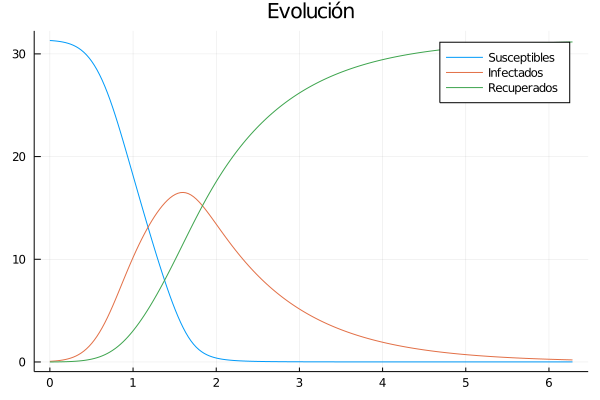

In [39]:
plot(T, vector_sumas, label = ["Susceptibles" "Infectados" "Recuperados"], 
    title="Evolución")

# Secuencial

In [40]:
function EDP_secuencial()
    U = Array{FE_function_type(),3}(undef, N_intervalos+1, n_iter+1,3);
    Fn = Array{FE_function_type(),2}(undef, N_intervalos+1,3);
    Gn = Array{FE_function_type(),2}(undef, N_intervalos+1,3);
    G0 = Array{FE_function_type(),2}(undef, N_intervalos+1,3);

    # 1.a) Inicialización (aproximción grosera)
    S0_sol = u0_guardar[1]
    I0_sol = u0_guardar[2]
    R0_sol = u0_guardar[3]
    
    U[1,1,1] = 1*S0_sol
    U[1,1,2] = 1*I0_sol
    U[1,1,3] = 1*R0_sol


    for n=1:N_intervalos
        G0[n+1,1], G0[n+1, 2], G0[n+1, 3] = 1*G( T[n+1],T[n],U[n,1,:] )
        U[n+1,1,:] = G0[n+1,:]
    end
    
        
    # 1.b) Inicialización etapas parareal
    for k=1:n_iter
        U[1,k+1,1], U[1,k+1,2], U[1,k+1,3] = 1*S0_sol, 1*I0_sol, 1*R0_sol 
    end

    # 2) Bucle parareal
    for k=1:n_iter
 
        # 2.a) Aproximación fina (paralela) en cada subintervalo
        for n = 1:N_intervalos
            Fn[n,1], Fn[n,2], Fn[n,3]  = 1*F( T[n+1], T[n], U[n,k,:] )
        end
        
        # 2.b) Corrección secuencial
        for n = 1:N_intervalos
            Gn[n+1,1], Gn[n+1, 2], Gn[n+1, 3] = 1*G( T[n+1],T[n],U[n,k+1,:] )
            U[n+1, k+1, 1] = Fn[n,1] + Gn[n+1,1] - G0[n+1,1]
            U[n+1, k+1, 2] = Fn[n,2] + Gn[n+1,2] - G0[n+1,2]
            U[n+1, k+1, 3] = Fn[n,3] + Gn[n+1,3] - G0[n+1,3]
        end
        G0 = Gn
    end
    
    return U
    
end

EDP_secuencial (generic function with 1 method)

In [41]:
@time U_SIR_sec = EDP_secuencial();

3456.690957 seconds (2.74 G allocations: 1.264 TiB, 4.17% gc time)


In [46]:
for i=1:N_intervalos+1
    sol = U_SIR_sec[i,end,1]
    writevtk(Ω,"Susceptibles_Secuencial$(lpad(i,2,'0'))",
        cellfields=["susceptibles" => sol])
end

In [47]:
for i=1:N_intervalos+1
    sol = U_SIR_sec[i,end,2]
    writevtk(Ω,"Infectados_Secuencial$(lpad(i,2,'0'))",
        cellfields=["infectados" => sol])
end

In [48]:
for i=1:N_intervalos+1
    sol = U_SIR_sec[i,end,3]
    writevtk(Ω,"Recuperados_Secuencial$(lpad(i,2,'0'))",
        cellfields=["recuperados" => sol])
end

# Diferencia

In [61]:
dif = U_SIR[:,:,:] - U_SIR_sec[:,:,:];

In [55]:
for i=1:N_intervalos+1
    sol = dif[i,end,1]
    writevtk(Ω,"Diferencia_S$(lpad(i,2,'0'))",
        cellfields=["susceptibles" => sol])
end

In [56]:
for i=1:N_intervalos+1
    sol = dif[i,end,2]
    writevtk(Ω,"Diferencia_I$(lpad(i,2,'0'))",
        cellfields=["infectados" => sol])
end

In [57]:
for i=1:N_intervalos+1
    sol = dif[i,end,3]
    writevtk(Ω,"Diferencia_R$(lpad(i,2,'0'))",
        cellfields=["recuperados" => sol])
end

In [59]:
dif_S = [ sum(∫(dif[i,end,1])*dΩ) for i in 1:N_intervalos+1]
dif_I = [ sum(∫(dif[i,end,2])*dΩ) for i in 1:N_intervalos+1]
dif_R = [ sum(∫(dif[i,end,3])*dΩ) for i in 1:N_intervalos+1]
vector_difs = [dif_S,dif_I, dif_R ];

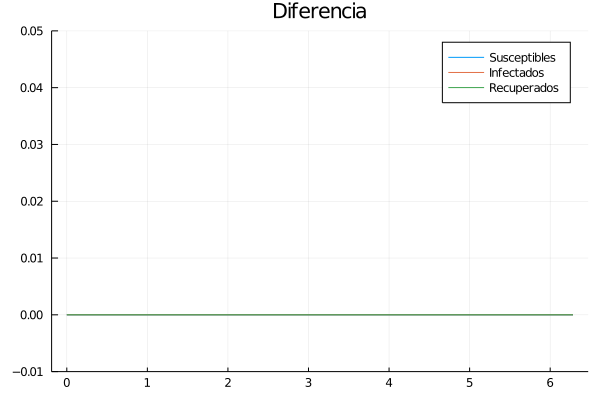

In [87]:
plot(T, vector_difs, label = ["Susceptibles" "Infectados" "Recuperados"], 
    title="Diferencia", ylims=(-0.01,0.05))

# Euler

In [65]:
N_total = N_intervalos*t_n_f*n_iter
@time resultado = EulerMEF(t_init, t_end, N_total,U_init);

2792.304527 seconds (2.07 G allocations: 1013.638 GiB, 4.16% gc time)


In [68]:
dif1 = resultado - U_SIR[end,end, :]

3-element Array{Gridap.CellData.OperationCellField{ReferenceDomain},1}:
 OperationCellField()
 OperationCellField()
 OperationCellField()

In [89]:
dif_Sum = [ sum(∫(abs(dif1[i]))*dΩ) for i in 1:3]
resultado_sum = [ sum(∫(abs(resultado[i]))*dΩ) for i in 1:3]
error_absoluto = sqrt( sum(dif_Sum.*2) ) 
error_relativo = error_absoluto / sqrt(sum(resultado_sum.^2))
println("Diferencia entre el método de Euler y Parareal/Euler en 
    la última iteración:")
println("Error absoluto: $error_absoluto.\nError relativo: $error_relativo")

Diferencia entre el método de Euler y Parareal/Euler en la última iteración:
Error absoluto: 0.012031541550664836.
Error relativo: 0.0003861032413732036
